Files needed for this demo:
* tabulated_logE_sindec_aeff_full.pckl
* bckg_flux_vals.pickle
* energy_smearing_kde.pckl
* e_psi_grid.pickle

# Imports

In [1]:
import pickle
import numpy as np
from os.path import join
import warnings
from copy import deepcopy
from matplotlib import pyplot as plt
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2
from scipy.interpolate import RegularGridInterpolator
warnings.filterwarnings("ignore")


In [2]:
from matplotlib.colors import LogNorm

# set your path here
BASEPATH = "/home/lisajsch/repos/Plenum/"

# Source parameters

In [3]:
# livetime of 10yrs in seconds
LIVETIME = 365 * 10 * 24 * 3600
# Normalization energy of power law (E/E0)^gamma
E0 = 1E3
# Source flux spectral index
GAMMA = 2.5
PHI_0 = 1E-14 # neutrinos * (E/E0)^gamma / GeV / cm^2 / s
# source declination
SRC_DEC = 0 # radian => source at horizon

# analysis region in distance to source
delta_psi = 2

# Functions

In [4]:
def get_mids(bins, ext=False):
    """ Calculate the bin mids from an array of bins """
    res = (bins[1:] + bins[:-1]) * 0.5
    if ext==False:
        return res
    else:
        res[0], res[-1] = bins[0], bins[-1]
        return res

In [5]:
def energy_smearing(ematrix, ev):
    """Translate a matrix with axis in true energy to reconstructed energy"""
    return (ematrix @ ev.T).T

In [6]:
def atmo_background(aeff_factor, bckg_flux_vals, normed_kvals):
    """Calculate the number of neutrinos of atmospheric background flux as a function reconstructed energy"""
    return energy_smearing(normed_kvals, aeff_factor * bckg_flux_vals)


In [7]:
def array_source_interp(dec, array, sindec_bins):
    """Take a 2D array and interpolate its values
    based on a value (dec) on the second axis"""

    sindec_mids = get_mids(sindec_bins)
    low_ind = np.digitize(np.sin(dec), sindec_bins) - 1

    if low_ind >= (len(sindec_mids)-1):
        array_interp = array[:, -1]
    elif low_ind == 0:
        array_interp = array[:, low_ind]
    else:
        if sindec_mids[low_ind] > np.sin(dec):
            low_ind -= 1
        array_interp = np.zeros(len(array))
        for i in range(len(array)):
            array_interp[i] = np.interp(
                np.sin(dec),
                [sindec_mids[low_ind], sindec_mids[low_ind + 1]],
                [array[i, low_ind], array[i, low_ind + 1]],
            )
    return array_interp


# Get the effective area

In [8]:
# use only upgoing data to mimick up-going muon track data set
with open(join(BASEPATH, "resources/tabulated_logE_sindec_aeff_full.pckl"), "rb") as f:
    logE_bins, sindec_bins, aeff_2d = pickle.load(f)

logE_mids = get_mids(logE_bins)
# cut at E=10⁹GeV
logE_bins = logE_bins[logE_bins<=9]
aeff_2d = aeff_2d["IceCube"][logE_mids<=9]
logE_mids = logE_mids[logE_mids<=9]


ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")


35 log_10(energy) bins
50 declination bins


(2.0, 9.0)

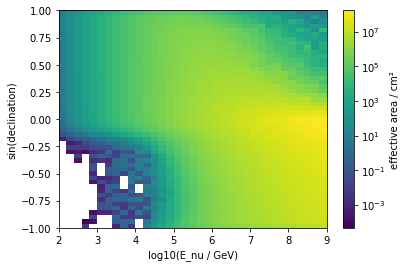

In [9]:
plt.pcolormesh(logE_bins, sindec_bins, aeff_2d.T, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("effective area / cm²")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)

# Background

In [10]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
# re-bin the atmospheric background flux
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(flux_def["numu_conv"])
)
# baseline evaluation
ss, em = np.meshgrid(sindec_mids, emids)
bckg_flux_vals = np.exp(rgi((em, ss))).T

(2.0, 9.0)

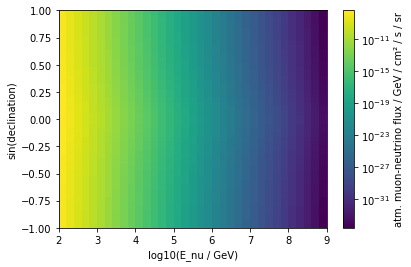

In [11]:
plt.pcolormesh(logE_bins, sindec_bins, bckg_flux_vals, norm=LogNorm())
cb = plt.colorbar()
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr")
plt.ylabel("sin(declination)")
plt.xlabel("log10(E_nu / GeV)")
plt.xlim(2, 9)

# Energy smearing

In [12]:
# energy smearing matrix as an interpolation function
with open(join(BASEPATH, "resources/energy_smearing_2D.pckl"), "rb") as f:
    normed_kvals, _logE_bins, _logE_reco_bins = pickle.load(f)

# construct an interpolator to match the aeff binning
rgi = RegularGridInterpolator((get_mids(_logE_reco_bins), get_mids(_logE_bins)), normed_kvals)

# new binning
logE_reco_bins = np.arange(1.9, 9.02, step=0.05)
logE_reco_mids = get_mids(logE_reco_bins)

# logE_mids is from the effective area binning
lge_grid, lre_grid = np.meshgrid(logE_mids, logE_reco_mids)

# baseline evaluation of the interpolation function 'rgi'
normed_kvals = rgi((lre_grid, lge_grid))

# normalize per bin in true energy
normed_kvals = normed_kvals / np.sum(normed_kvals, axis=0)

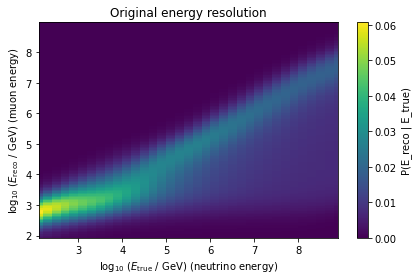

In [13]:
# logE_mids are the same as for effective area binning
egrid_true, egrid_reco = np.meshgrid(logE_mids, logE_reco_mids)

f, axes = plt.subplots()

axes.grid(False)
im = axes.pcolormesh(egrid_true, egrid_reco, normed_kvals)
axes.set_ylim(np.min(egrid_reco), np.max(egrid_reco))
axes.set_xlim(np.min(egrid_true), np.max(egrid_true))
axes.set_title("Original energy resolution")
axes.set_ylabel(r"$\log_{10}$ ($E_{\rm reco}$ / GeV) (muon energy)")
axes.set_xlabel(r"$\log_{10}$ ($E_{\rm true}$ / GeV) (neutrino energy)")
cb = f.colorbar(im)
cb.set_label("P(E_reco | E_true)")
f.tight_layout()

# Source flux definition

In [14]:
def astro_flux(
    aeff_factor,
    emids,
    E0,
    gamma,
    phi_scaling,
):
    """
    flux shape: dphi/dE = phi_0 * (E/E0) ** -gamma
    powerlaw parameters:
        * gamma
        * phi scaling (phi normalization will be phi_0 * phi scaling) 
          -> actual fit parameter will be of magnitude 1 instead of E-14
    """
    tmp = aeff_factor * (emids/E0)**(-gamma) * PHI_0 * phi_scaling
    return energy_smearing(normed_kvals, tmp)

# calculate number of events per source as crosscheck

(should be 39.6 events in total)

In [15]:
aeff_factor_signal = (
    array_source_interp(SRC_DEC, aeff_2d, sindec_bins) * LIVETIME * ewidth
)
# this is only 1D in energy dimension
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    E0,
    GAMMA,
    1,
)
print(np.sum(k_s))


39.62833474801221


# Psi-Energy histogram

Going 2D now with angular distance 'Psi'

In [16]:
with open(join(BASEPATH, "resources/e_psi_grid.pickle"), "rb") as f:
    # 2D histogram in log(E) and psi²
    e_psi2_grid = pickle.load(f)
# cut to right size in energy
e_psi2_grid = e_psi2_grid[:, :len(logE_mids)]

In [17]:
# Background is uniform in psi²
# so we generate a matching uniform histogram here
bckg_grid = np.ones_like(e_psi2_grid)
bckg_grid /= np.sum(bckg_grid, axis=0)


### Full nominal (=Asimov) histograms in Psi - log(E)

Fit parameters for analysis:
* Global normalization of k_b
* Global normalization of k_s
* Spectral index of k_s (=gamma)

In [18]:
aeff_factor_bckg = (
    (
        array_source_interp(SRC_DEC, aeff_2d, sindec_bins)
        * LIVETIME
        * ewidth
        * (np.deg2rad(delta_psi) ** 2)
        * np.pi  # solid angle approx.
    )
    * bckg_grid
    * 1
)  ## nominal value, FIT PARAMETER

aeff_factor_signal = (
    array_source_interp(SRC_DEC, aeff_2d, sindec_bins) * LIVETIME * ewidth * e_psi2_grid
)
# model expectation before adding fit parameters
mu_b_base = deepcopy(aeff_factor_bckg)
mu_s_base = deepcopy(aeff_factor_signal)

# asimov data
k_b = atmo_background(
    aeff_factor_bckg,
    array_source_interp(SRC_DEC, bckg_flux_vals.T, sindec_bins).T,
    normed_kvals,
)
k_s = astro_flux(
    aeff_factor_signal,
    emids,
    E0,
    GAMMA,  ## FIT PARAMETER
    1,  ## FIT PARAMETER
)
k_i = k_s + k_b

print("Asimov data sum:")
print("Background:", np.sum(k_b))  # ~550
print("Signal:", np.sum(k_s))  # ~40
print("S+B", np.sum(k_i))  # ~590


Asimov data sum:
Background: 549.8420471647463
Signal: 39.62833474801221
S+B 589.4703819127584


## some plotting

In [19]:
delta_psi = 2
psi2_bins = np.linspace(0, delta_psi**2, delta_psi**2 * 25 + 1)

Text(0.5, 1.0, 'Signal point-source flux')

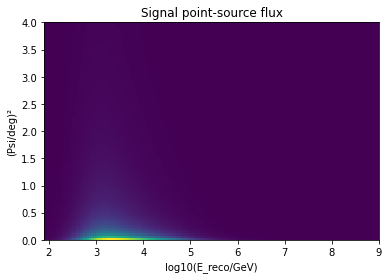

In [20]:
plt.pcolormesh(logE_reco_bins, psi2_bins, k_s)
plt.ylabel("(Psi/deg)²")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Signal point-source flux")

Text(0.5, 1.0, 'Background atmospheric flux')

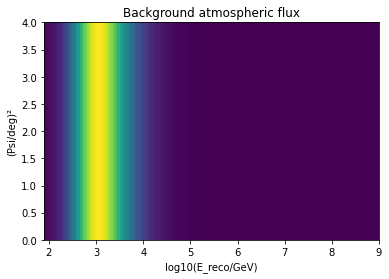

In [21]:
plt.pcolormesh(logE_reco_bins, psi2_bins, k_b)
plt.ylabel("(Psi/deg)²")
plt.xlabel("log10(E_reco/GeV)")
plt.title("Background atmospheric flux")

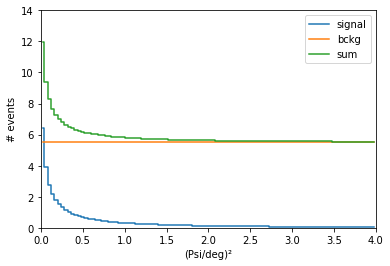

In [22]:
# summed 1D hist in psi²
plt.plot(get_mids(psi2_bins), k_s.sum(axis=1), ds="steps-mid", label="signal")
plt.plot(get_mids(psi2_bins), k_b.sum(axis=1), ds="steps-mid", label="bckg")
plt.plot(get_mids(psi2_bins), k_i.sum(axis=1), ds="steps-mid", label="sum")
plt.ylim(0, 14)
plt.xlim(0, 4)
plt.xlabel("(Psi/deg)²")
plt.ylabel("# events")
plt.legend()

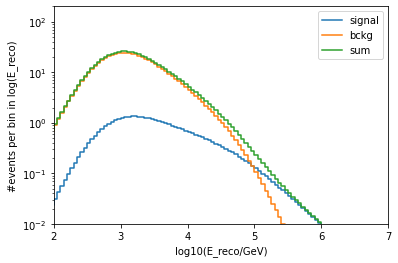

In [23]:
plt.plot(logE_reco_mids, k_s.sum(axis=0), ds="steps-mid", label="signal")
plt.plot(logE_reco_mids, k_b.sum(axis=0), ds="steps-mid", label="bckg")
plt.plot(logE_reco_mids, k_i.sum(axis=0), ds="steps-mid", label="sum")
plt.yscale("log")
plt.xlim(2, 7)
plt.ylim(1E-2, 2E2)
plt.ylabel("#events per bin in log(E_reco)")
plt.xlabel("log10(E_reco/GeV)")
plt.legend()

### DEMO: Significance test Background vs. Background + Signal

In [24]:
def ps_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0=E0,
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal spectral index
    x[2]: signal normalization scaling

    mu_b_base: effective area factor for background
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        array_source_interp(SRC_DEC, bckg_flux_vals.T, sindec_bins).T,
        normed_kvals,
    )
    mu_s = astro_flux(mu_s_base, emids, e_0, *x[1:])
    mu_i = mu_s + mu_b
    # -2 Log Likelihood (B/S)
    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


In [25]:
# define the fitting functions with all parameters
# background only, 1 free parameter
local_llh = lambda x: ps_llh_2d_composite(
    (x[0], 2, 0), mu_b_base, mu_s_base, k_i
)
# background + signal, 3 free parameters
global_llh = lambda x: ps_llh_2d_composite(
    x, mu_b_base, mu_s_base, k_i
)
# ... and fit both hypotheses!
out_bckg = fmin_l_bfgs_b(
    local_llh,
    x0=(1.2,),
    approx_grad=True,
)
print("Bckg-only normalization:", out_bckg[0])

out_comp = fmin_l_bfgs_b(
    global_llh,
    x0=(1.2, 3.0, 1.2),
    approx_grad=True,
)
print("Signal fit parameters:", out_comp[0])

# calculate p-value and significance with Wilks' and 2 d.o.f
pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
significance = erfinv(1 - pval) * np.sqrt(2)
print("P-VALUE:", pval, "SIGNIFICANCE:", significance)


Bckg-only normalization: [1.07207217]
Signal fit parameters: [0.99999863 2.49999399 0.99991145]
P-VALUE: 3.319663176987231e-05 SIGNIFICANCE: 4.150350651144509
